In [1]:
batch_size = 64
image_size = 256

In [2]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

In [4]:
# DATA_DIR = "/root/autodl-tmp/cervical_spine/"
DATA_DIR = "/Volumes/SSD970/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

TRAIN_CORONAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_coronal_images")
TRAIN_CORONAL_LABEL_DIR = os.path.join(DATA_DIR, "train_coronal_labels")
TRAIN_SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_sagittal_images")
TRAIN_SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "train_sagittal_labels")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, self.n_features, kernel_size=1, padding='same'),
            #             nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same')
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out


In [7]:
def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

In [8]:
backbone = resnet50_gray()
channels = [64, 512, 1024, 2048]
model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


77833514

In [9]:
state = torch.load("../train/checkpoint/sagittal_segmentation_detection_074132-epoch-20.pth", map_location=torch.device('cpu'))
# state = torch.load("../train/checkpoint/coronal_segmentation_detection_192117-epoch-20.pth", map_location=torch.device('cpu'))
model.load_state_dict(state["model"])
model = model.eval()

## Transform

In [10]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            # T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        # self.target_transform = T.Compose([
        #     T.Resize(image_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST),
        #     T.PILToTensor(),
        #     T.Lambda(lambda x: x.float()),
        #     T.Normalize(0, 256)
        # ])

    def forward(self, x):
        # center_crop 을 height 으로 해라, 그렇지 않으면 inference 에서 결과가 좋지 않았다.
        # training 에서는 max 로 하는게 더 좋을까?
        x = TF.center_crop(x, max(x.width, x.height))
        # x = TF.center_crop(x, [x.height, x.height])
        x = self.transform(x)

        # y = TF.center_crop(y, max(y.width, y.height))
        # y = self.target_transform(y)

        # return x, y
        return x
transform = DataTransform(image_size)

## Dataset

In [11]:
class VerticalImageDataset(Dataset):
    def __init__(self, df, train_image_dir, transform=None):
        super().__init__()
        self.df = df
        self.train_image_dir = train_image_dir

        self.transform = transform

    def __len__(self):
        return len(self.df) * 512

    def __getitem__(self, idx):
        UID = self.df.iloc[idx//512].UID
        image_name = int(idx % 512)
        image_path = os.path.join(self.train_image_dir, UID, f"{image_name}.jpeg")
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, UID, image_name

## Inference

In [12]:
df = pd.read_csv(os.path.join(DATA_DIR, 'meta_train_3d.csv'))
print(len(df))
df.head()

2012


,UID,z_spacing,pixel_spacing,aspect,is_flip
0,1.2.826.0.1.3680043.10001,0.625,0.253906,2.461541,0
1,1.2.826.0.1.3680043.10005,0.625,0.298828,2.091504,0
2,1.2.826.0.1.3680043.10014,0.800,0.234000,3.418803,0
3,1.2.826.0.1.3680043.10016,0.313,0.275391,1.136566,0
4,1.2.826.0.1.3680043.10032,0.625,0.320313,1.951216,0


### Inference Coronal images

### set coronal or segittal

In [13]:
# inference_images_dir = TRAIN_CORONAL_IMAGES_DIR
# inference_labels_dir = TRAIN_CORONAL_LABEL_DIR
inference_images_dir = TRAIN_SAGITTAL_IMAGES_DIR
inference_labels_dir = TRAIN_SAGITTAL_LABEL_DIR

In [14]:

dataset = VerticalImageDataset(df, inference_images_dir, transform)
len(dataset)

1030144

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 6 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
@torch.no_grad()
def predict(model, x):
    x = x.to(device)
    classification_prob, mse_score = model(x).sigmoid().chunk(2, dim=1)
    mse_score = torch.round(mse_score * 8.) / 8.
    pred = classification_prob.gt(0.5).float() * mse_score
    return pred

In [17]:
# dataset[0]

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/SSD970/train_sagittal_images/1.2.826.0.1.3680043.10001/0.jpeg'

In [ ]:
def save_pred_image(pred, UIDs, image_names):
    pred = pred * 32
    for i in range(pred.shape[0]):
        label_dir = os.path.join(inference_labels_dir, UIDs[i])
        if os.path.exists(label_dir) == False:
            os.mkdir(label_dir)
        label = pred[i, 0, :, :]
        img_path = os.path.join(label_dir, f"{image_names[i]}.png")
        img_full_path = os.path.join(inference_labels_dir, img_path)
        Image.fromarray(np.uint8(label), 'L').save(img_full_path)

In [ ]:
# with torch.no_grad():
#     train_iter = tqdm(dataloader)
#     for x, UIDs, image_names in train_iter:
#
#         pred = predict(model, x)
#         save_pred_image(pred.cpu().numpy(), UIDs, image_names)

Inference one image

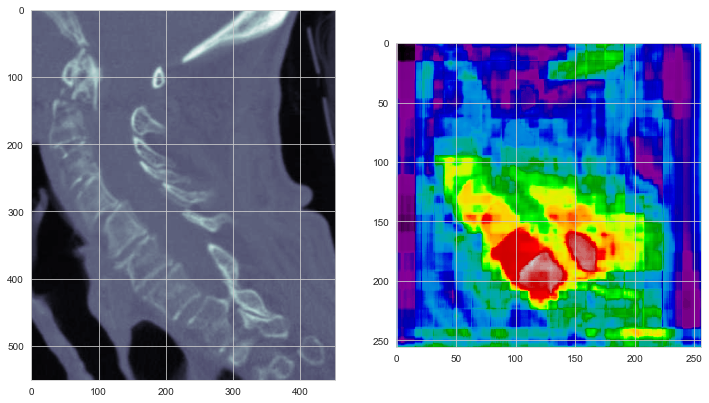

In [21]:
@torch.no_grad()
def infer_image(model, image_path, transform):
    pil_img = Image.open(image_path)
    # pil_img = pil_img.rotate(-90)

    img = transform(pil_img)


    x = img.unsqueeze(0)
    # pred = predict(model, x)
    classification_prob, mse_score = model(x).sigmoid().chunk(2, dim=1)
    pred = mse_score

    _, axs = plt.subplots(1, 2, figsize=(12, 12))
    axs[0].imshow(pil_img, cmap='bone')
    axs[1].imshow(pred.squeeze().cpu().numpy(), cmap='nipy_spectral')


# infer_image(model, os.path.join(DATA_DIR, "train_sagittal_images", "1.2.826.0.1.3680043.16935", "272.jpeg"), transform)
# infer_image(model, os.path.join(DATA_DIR, "train_sagittal_images", "1.2.826.0.1.3680043.8362", "248.jpeg"), transform)
# infer_image(model, os.path.join(TRAIN_CORONAL_IMAGES_DIR, "1.2.826.0.1.3680043.16935", "288.jpeg"), transform)
infer_image(model, "326-2.jpeg", transform)


특정된 부위를 crop 하기

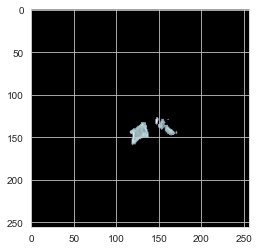

In [27]:
def crop_spine(img, pred, spine):
    img = TF.center_crop(img, min(img.width, img.height))
    img = TF.resize(img, image_size)
    mask = np.copy(pred)
    mask[mask != (spine * 0.125)] = 0
    mask[mask > 0] = 1
    img = np.asarray(img) * mask
    plt.imshow(img, cmap='bone')
pil_img = Image.open("251.jpeg")
img = transform(pil_img)
x = img.unsqueeze(0)
pred = predict(model, x).squeeze().cpu().numpy()
crop_spine(pil_img, pred, 5)

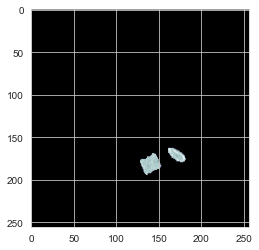

In [49]:
crop_spine(pil_img, pred, 7)